In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

import matplotlib.pyplot as plt

## timeseries package
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import timedelta
from numpy import log

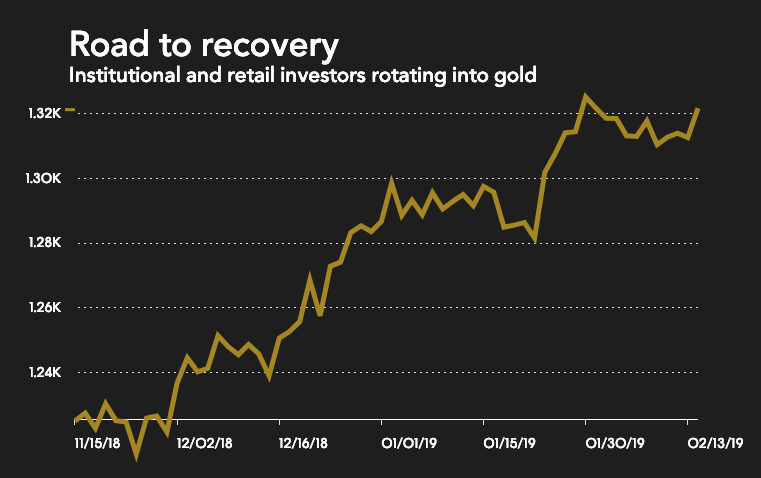

### Problem

- Forecast the 22K or 24K Gold price

In [4]:
df.head()

,Date,Country,State,Location,Pure Gold (24 k),Standard Gold (22 K)
0,1/2/2006,India,Tamilnadu,Chennai,768.0,711.0
1,1/3/2006,India,Tamilnadu,Chennai,770.5,713.0
2,1/4/2006,India,Tamilnadu,Chennai,784.5,726.0
3,1/5/2006,India,Tamilnadu,Chennai,782.5,725.0
4,1/6/2006,India,Tamilnadu,Chennai,776.0,719.0


In [2]:
df = pd.read_csv('gold_rate_history.csv')
df.shape

(4958, 6)

Lets look at the data fields.

In [3]:
df.columns

Index(['Date', 'Country', 'State', 'Location', 'Pure Gold (24 k)',
       'Standard Gold (22 K)'],
      dtype='object')

In [7]:
print(f"The dataset available for State: {df['State'].unique()[0]} and City: {df['Location'].unique()[0]}")

The dataset available for State: Tamilnadu and City: Chennai


Convert Datetime object

In [8]:
## Convert date string to datetime object
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")

In [9]:
print(f'The date ranging from {df["Date"].min()} to {df["Date"].max()}')

The date ranging from 2006-01-02 00:00:00 to 2020-09-27 00:00:00


In [10]:
df

,Date,Country,State,Location,Pure Gold (24 k),Standard Gold (22 K)
0,2006-01-02,India,Tamilnadu,Chennai,768.0,711.0
1,2006-01-03,India,Tamilnadu,Chennai,770.5,713.0
2,2006-01-04,India,Tamilnadu,Chennai,784.5,726.0
3,2006-01-05,India,Tamilnadu,Chennai,782.5,725.0
4,2006-01-06,India,Tamilnadu,Chennai,776.0,719.0
...,...,...,...,...,...,...
4953,2020-09-23,India,Tamilnadu,Chennai,5061.0,4820.0
4954,2020-09-24,India,Tamilnadu,Chennai,5002.0,4764.0
4955,2020-09-25,India,Tamilnadu,Chennai,5028.0,4789.0
4956,2020-09-26,India,Tamilnadu,Chennai,5019.0,4780.0


In [11]:
# convert data type
df["Pure Gold (24 k)"] = df["Pure Gold (24 k)"].astype(np.float)
df["Standard Gold (22 K)"] = df["Standard Gold (22 K)"].astype(np.float)

In [12]:
df.index = df.Date

In [13]:
df.head()

,Date,Country,State,Location,Pure Gold (24 k),Standard Gold (22 K)
Date,,,,,,
2006-01-02,2006-01-02,India,Tamilnadu,Chennai,768.0,711.0
2006-01-03,2006-01-03,India,Tamilnadu,Chennai,770.5,713.0
2006-01-04,2006-01-04,India,Tamilnadu,Chennai,784.5,726.0
2006-01-05,2006-01-05,India,Tamilnadu,Chennai,782.5,725.0
2006-01-06,2006-01-06,India,Tamilnadu,Chennai,776.0,719.0


## How Gold price has increased over a decade?

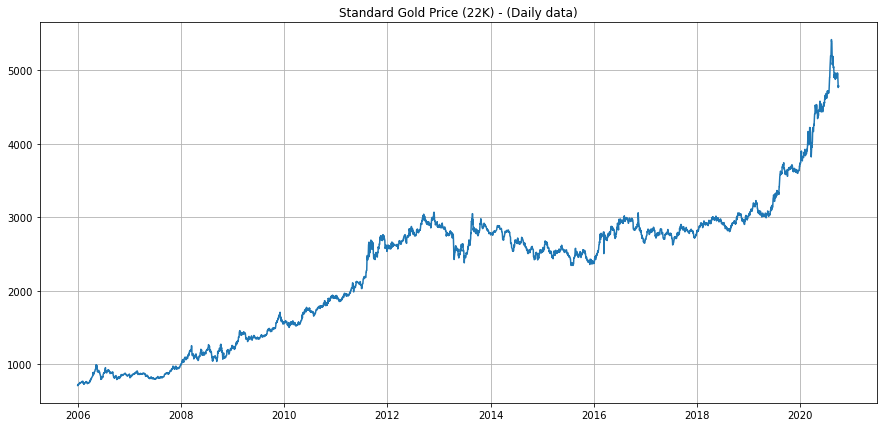

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(df['Standard Gold (22 K)'])
plt.title('Standard Gold Price (22K) - (Daily data)')
plt.grid(True)
plt.show()

The price is not consistent over the period of time. Yup. There could be many other factor which directly influence the gold price like increasing the US dollar value for Indian curreny, oil price and etc.

But, Will treat this as **Univariate Time series Forecasting** problem now.

## ARIMA model

The important parameters of ARIMA is p, d and q. Lets see how to determine each parameter.

In [15]:
result = adfuller(df['Standard Gold (22 K)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.384957
p-value: 0.980924


P value is not significant 0.05 hence the data is not stationary. it required order of differencing (D).

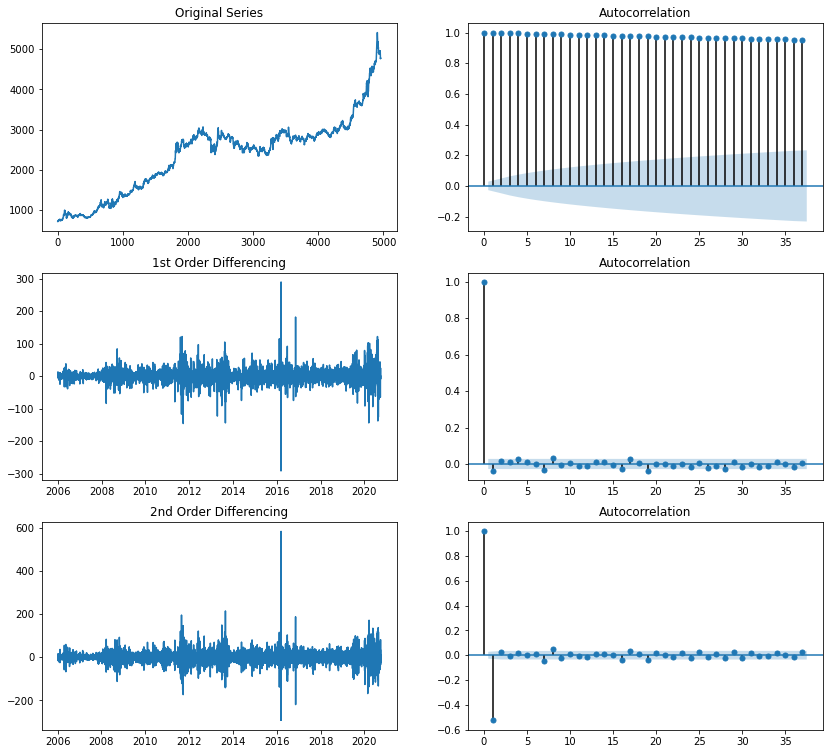

In [17]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)

fig.set_size_inches(14,13)

axes[0, 0].plot(df['Standard Gold (22 K)'].values); axes[0, 0].set_title('Original Series')
plot_acf(df['Standard Gold (22 K)'].values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['Standard Gold (22 K)'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Standard Gold (22 K)'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['Standard Gold (22 K)'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Standard Gold (22 K)'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with one orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

**Will fix order of differencing as 1.** This is the **d** term in ARIMA.

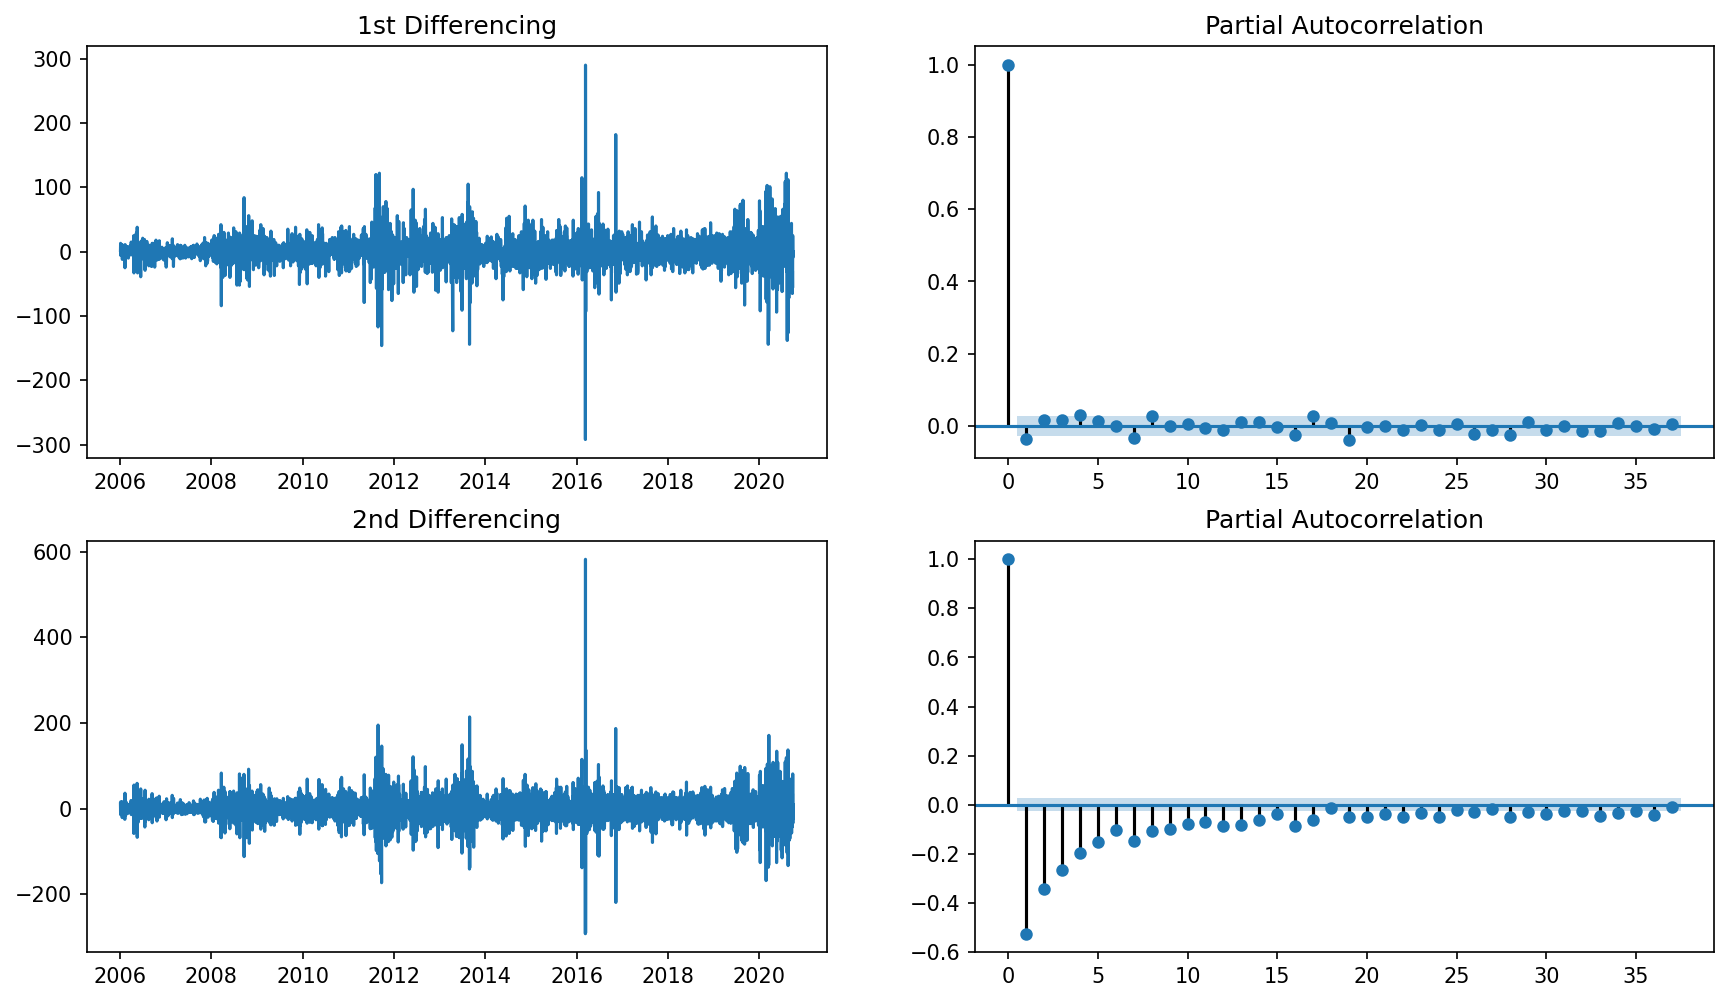

In [19]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(14,8), 'figure.dpi':150})

## first order differencing
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(df['Standard Gold (22 K)'].diff()); axes[0, 0].set_title('1st Differencing')
plot_pacf(df['Standard Gold (22 K)'].diff().dropna(), ax=axes[0, 1])

## second order differencing
axes[1, 0].plot(df['Standard Gold (22 K)'].diff().diff()); axes[1, 0].set_title('2nd Differencing')
plot_pacf(df['Standard Gold (22 K)'].diff().diff().dropna(), ax=axes[1, 1])

plt.show()

 PACF lag 1 is quite significant since is well above the significance line. 
 
 **Hence, P value will tentatively fix 1**

In [20]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df['Standard Gold (22 K)'], order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\Elvis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Elvis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               ARIMA Model Results                                
Dep. Variable:     D.Standard Gold (22 K)   No. Observations:                 4957
Model:                     ARIMA(1, 1, 2)   Log Likelihood              -21923.565
Method:                           css-mle   S.D. of innovations             20.162
Date:                    Sun, 27 Sep 2020   AIC                          43857.130
Time:                            12:30:43   BIC                          43889.672
Sample:                                 1   HQIC                         43868.540
                                                                                  
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.8203      0.296      2.769      0.006       0.240       1.401
ar.L1.D.Standard Gold (22 K)     0.6944      

In [21]:
# Create Training and Test
train = df['Standard Gold (22 K)'][:-200]
test = df['Standard Gold (22 K)'][-200:]

print(train.shape, test.shape)

(4758,) (200,)


In [27]:
# Build Model
model = ARIMA(train, order=(1, 2, 1))  
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(test.shape[0], alpha=0.1)  # 90% conf

C:\Users\Elvis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Elvis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [28]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

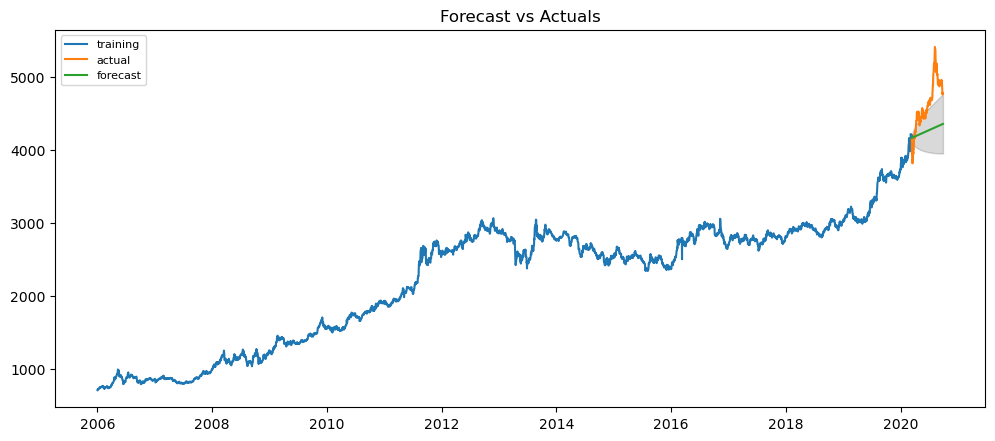

In [29]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Observation:

- Results are not good. Even, I tried changing the P, D and Q parameter for ARIMA. It didn't help much.

## Let's treat the problem as Regression

Will focus on the following points:
- Let's predict 22K Gold price in future
- Only single feature available 
- Feature engineering

### Lag Feature

In [30]:
NO_OF_LAG_DAYS = 14

In [31]:
def create_lag_feature(df, no_of_days):
    
    for day in range(1, no_of_days+1):
        df[f"lag_{day}"] = df["Standard Gold (22 K)"].shift(day)
        
    return df

In [32]:
df_features = create_lag_feature(df, NO_OF_LAG_DAYS)

In [33]:
lag_features =  [ col for col in df_features.columns if "lag" in col]
print(lag_features)

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14']


In [34]:
df_lag_features = df_features[lag_features + ['Standard Gold (22 K)']].dropna()
df_lag_features.columns

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14',
       'Standard Gold (22 K)'],
      dtype='object')

In [35]:
train_df = df_lag_features[:-500]
test_df = df_lag_features[-500:]
print(train_df.shape, test_df.shape)

(4444, 15) (500, 15)


## Regression model

In [36]:
import xgboost as xgb
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [37]:
model = mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=12,
                           max_iter=100, random_state=5,
                           activation="relu") 

In [38]:
X_train_df = train_df[lag_features]
X_test_df = test_df[lag_features]

In [39]:
model.fit(X_train_df, train_df['Standard Gold (22 K)'])

C:\Users\Elvis\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(hidden_layer_sizes=12, max_iter=100, random_state=5,
             solver='lbfgs')

In [44]:
X_test_df

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
Date,,,,,,,,,,,,,,
2019-05-17,3070.0,3083.0,3085.0,3054.0,3052.0,3052.0,3038.0,3040.0,3030.0,3022.0,3017.0,3012.0,3012.0,2992.0
2019-05-18,3058.0,3070.0,3083.0,3085.0,3054.0,3052.0,3052.0,3038.0,3040.0,3030.0,3022.0,3017.0,3012.0,3012.0
2019-05-19,3050.0,3058.0,3070.0,3083.0,3085.0,3054.0,3052.0,3052.0,3038.0,3040.0,3030.0,3022.0,3017.0,3012.0
2019-05-20,3050.0,3050.0,3058.0,3070.0,3083.0,3085.0,3054.0,3052.0,3052.0,3038.0,3040.0,3030.0,3022.0,3017.0
2019-05-21,3016.0,3050.0,3050.0,3058.0,3070.0,3083.0,3085.0,3054.0,3052.0,3052.0,3038.0,3040.0,3030.0,3022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,4850.0,4915.0,4958.0,4958.0,4942.0,4919.0,4947.0,4960.0,4916.0,4900.0,4900.0,4905.0,4920.0,4909.0
2020-09-24,4820.0,4850.0,4915.0,4958.0,4958.0,4942.0,4919.0,4947.0,4960.0,4916.0,4900.0,4900.0,4905.0,4920.0
2020-09-25,4764.0,4820.0,4850.0,4915.0,4958.0,4958.0,4942.0,4919.0,4947.0,4960.0,4916.0,4900.0,4900.0,4905.0


In [45]:
predicted_price = model.predict(X_test_df)
test_df["22K Gold Predicted_Price"] = predicted_price

C:\Users\Elvis\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
test_df[["Standard Gold (22 K)", "22K Gold Predicted_Price"]].head()

,Standard Gold (22 K),22K Gold Predicted_Price
Date,,
2019-05-17,3058.0,3076.833441
2019-05-18,3050.0,3070.994709
2019-05-19,3050.0,3050.566406
2019-05-20,3016.0,3047.590696
2019-05-21,3020.0,3021.844293


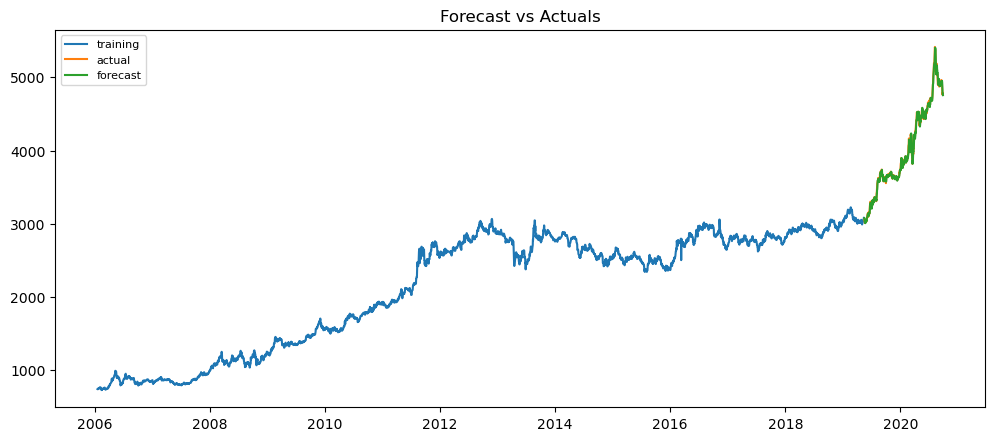

In [47]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df['Standard Gold (22 K)'], label='training')
plt.plot(test_df['Standard Gold (22 K)'], label='actual')
plt.plot(test_df['22K Gold Predicted_Price'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [48]:
print(f"RMSE {mean_squared_error(test_df['Standard Gold (22 K)'], test_df['22K Gold Predicted_Price'], squared= False)}")

RMSE 37.659429421183674


### Well done!!!

Achieved better RMSE in regression model rather than considering it as Time series problem (Exspecially ARIMA didn't work well, but other time series model need to try).